In [10]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath("../"))

In [11]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch import optim
import numpy as np
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
import random
from models.unet import UNet
from models.slim_unet import SlimUNet
from data_loader import prepare_datasets
from evaluate import dice_coeff,iou_score

# Suppress warnings
warnings.filterwarnings("ignore")

In [12]:
def train_epoch(model, train_loader, optimizer, criterion, device, accumulation_steps=4):
    model.train()
    epoch_loss = 0.0
    scaler = GradScaler()
    optimizer.zero_grad()

    with tqdm(total=len(train_loader), desc='Training') as pbar:
        for i, (images, masks, _) in enumerate(train_loader):  # Discard label
            images, masks = images.to(device), masks.to(device)

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks) / accumulation_steps

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            epoch_loss += loss.item() * accumulation_steps
            pbar.update(1)
            pbar.set_postfix({'loss': loss.item() * accumulation_steps})

    return epoch_loss / len(train_loader)

In [13]:
def validate(model, val_loader, criterion, device, threshold=0.5, visualize=False):
    model.eval()
    val_metrics = {
        'loss': 0.0, 'dice': 0.0, 'iou': 0.0,
        'precision': 0.0, 'recall': 0.0, 'f1': 0.0,
        'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0
    }
    val_count = 0
    per_image_metrics = []
    fig = None

    with torch.no_grad():
        for images, masks, _ in tqdm(val_loader, desc='Validation'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            sigmoid_outputs = torch.sigmoid(outputs)
            
            val_metrics['loss'] += criterion(outputs, masks).item()
            pred = (sigmoid_outputs > threshold).float()
            
            # Visualization
            if visualize and fig is None and images.size(0) > 0:
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(images[0].cpu().permute(1, 2, 0)[:, :, :3])
                axes[0].set_title("Input")
                axes[1].imshow(masks[0].cpu().squeeze(), cmap='gray')
                axes[1].set_title("Ground Truth")
                axes[2].imshow(pred[0].cpu().squeeze(), cmap='gray')
                axes[2].set_title(f"Prediction (th={threshold:.2f})")
                plt.show()
            
            # Metrics calculation
            batch_metrics = {}
            batch_metrics['dice'] = dice_coeff(sigmoid_outputs, masks).item()
            batch_metrics['iou'] = iou_score(sigmoid_outputs, masks).item()
            
            pred_flat = pred.view(-1)
            masks_flat = masks.view(-1)
            
            tp = torch.sum((pred_flat == 1) & (masks_flat == 1)).item()
            fp = torch.sum((pred_flat == 1) & (masks_flat == 0)).item()
            tn = torch.sum((pred_flat == 0) & (masks_flat == 0)).item()
            fn = torch.sum((pred_flat == 0) & (masks_flat == 1)).item()
            
            batch_metrics['precision'] = tp / (tp + fp) if (tp + fp) > 0 else 0
            batch_metrics['recall'] = tp / (tp + fn) if (tp + fn) > 0 else 0
            batch_metrics['f1'] = 2 * (batch_metrics['precision'] * batch_metrics['recall']) / (
                batch_metrics['precision'] + batch_metrics['recall']) if (
                batch_metrics['precision'] + batch_metrics['recall']) > 0 else 0
            
            for i in range(images.size(0)):
                per_image_metrics.append({
                    'dice': dice_coeff(sigmoid_outputs[i:i+1], masks[i:i+1]).item(),
                    'iou': iou_score(sigmoid_outputs[i:i+1], masks[i:i+1]).item(),
                })
            
            for k in batch_metrics:
                val_metrics[k] += batch_metrics[k]
            
            val_metrics['tp'] += tp
            val_metrics['fp'] += fp
            val_metrics['tn'] += tn
            val_metrics['fn'] += fn
            val_count += 1
    
    # Calculate averages
    for k in ['loss', 'dice', 'iou', 'precision', 'recall', 'f1']:
        val_metrics[k] /= max(1, val_count)
    
    # Global metrics
    total_tp = val_metrics['tp']
    total_fp = val_metrics['fp']
    total_fn = val_metrics['fn']
    
    val_metrics['global_precision'] = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    val_metrics['global_recall'] = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    val_metrics['global_f1'] = 2 * (val_metrics['global_precision'] * val_metrics['global_recall']) / (
        val_metrics['global_precision'] + val_metrics['global_recall']) if (
        val_metrics['global_precision'] + val_metrics['global_recall']) > 0 else 0
    
    # Standard deviations
    dice_values = [m['dice'] for m in per_image_metrics]
    iou_values = [m['iou'] for m in per_image_metrics]
    val_metrics['dice_std'] = np.std(dice_values) if dice_values else 0
    val_metrics['iou_std'] = np.std(iou_values) if iou_values else 0
    
    return val_metrics

In [14]:
def find_optimal_threshold(model, val_loader, device, n_thresholds=20):
    model.eval()
    thresholds = np.linspace(0.1, 0.9, n_thresholds)
    best_threshold = 0.5
    best_f1 = 0.0

    with torch.no_grad():
        for th in thresholds:
            val_metrics = validate(model, val_loader, nn.BCEWithLogitsLoss(), device, threshold=th, visualize=False)
            if val_metrics['global_f1'] > best_f1:
                best_f1 = val_metrics['global_f1']
                best_threshold = th
    return best_threshold

In [ ]:
def compute_pos_weight(dataset):
    total_pos = 0
    total_neg = 0

    for item in dataset:
        if len(item) == 3:
            _, mask, _ = item  # Discard image and label
        else:
            _, mask = item  # Discard image
        
        # Assuming mask is shape (1, H, W) or (H, W)
        mask = mask.float()
        total_pos += mask.sum().item()
        total_neg += (1 - mask).sum().item()

    return total_neg / (total_pos + 1e-8)

class DicePixelLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DicePixelLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()

        # Dice Loss
        intersection = (probs * targets).sum(dim=(1,2,3))
        union = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice.mean()

        # Pixel-wise Loss
        preds = (probs > 0.5).float()
        pixel_acc = (preds == targets).float().mean()
        pixel_loss = 1 - pixel_acc

        # Total Loss
        total_loss = 0.3 * dice_loss + 0.7 * pixel_loss

        return total_loss

In [16]:
def test_model(model, test_loader, criterion, device):
    print("\nEvaluating on test set...")
    model.load_state_dict(torch.load('best_model.pth'))
    with open('best_threshold.txt', 'r') as f:
        best_threshold = float(f.read())
    
    test_metrics = validate(model, test_loader, criterion, device, best_threshold, visualize=True)
    
    print("\n--- Test Metrics ---")
    print(f"Validation Threshold Used: {best_threshold:.2f}")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Dice: {test_metrics['dice']:.4f}±{test_metrics['dice_std']:.4f}")
    print(f"Test IoU: {test_metrics['iou']:.4f}±{test_metrics['iou_std']:.4f}")
    print(f"Precision: {test_metrics['global_precision']:.4f} | Recall: {test_metrics['global_recall']:.4f} | F1: {test_metrics['global_f1']:.4f}")

In [17]:
def train_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Hyperparameters
    batch_size = 4
    accumulation_steps = 2  # Effective batch size = 8
    num_epochs = 50
    learning_rate = 1e-4
    patience = 10

    # Prepare data
    try:
        train_set, val_set, test_set = prepare_datasets('../data/processed')
    except Exception as e:
        print(f"Error preparing datasets: {e}")
        return
    
    pos_weight_value = compute_pos_weight(train_set)
    pos_weight = torch.tensor([pos_weight_value]).to(device)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                             num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                           num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

    # Initialize model
    model = SlimUNet(n_channels=4, n_classes=1).to(device)
    bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    dice = DicePixelLoss()
    
    def combined_loss_fn(logits, targets):
        return bce(logits, targets) + dice(logits, targets)
    
    criterion = combined_loss_fn
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)

    best_dice = 0.0
    best_threshold = 0.4
    no_improve = 0

    try:
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            
            # Training
            avg_train_loss = train_epoch(model, train_loader, optimizer, criterion, 
                                       device, accumulation_steps)
            
            # Validation with dynamic threshold
            threshold = find_optimal_threshold(model, val_loader, device,n_thresholds=7)
            metrics = validate(model, val_loader, criterion, device, 
                             threshold, visualize=(epoch % 10 == 0))
            
            print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {metrics['loss']:.4f}")
            print(f"Val Dice: {metrics['dice']:.4f}±{metrics['dice_std']:.4f} | Threshold: {threshold:.2f}")
            print(f"Precision: {metrics['global_precision']:.4f} | Recall: {metrics['global_recall']:.4f} | F1: {metrics['global_f1']:.4f}")

            # Early stopping and model saving
            if metrics['dice'] > best_dice:
                best_dice = metrics['dice']
                best_threshold = threshold
                torch.save(model.state_dict(), 'best_model.pth')
                with open('best_threshold.txt', 'w') as f:
                    f.write(str(best_threshold))
                no_improve = 0
                print(f"New best model! Val Dice: {best_dice:.4f}")
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"No improvement for {patience} epochs. Early stopping!")
                    break

            scheduler.step(metrics['dice'])

    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
        
    test_model(model, test_loader, criterion, device)

Using device: cuda
Train: 8458, Val: 1058, Test: 1058

Epoch 1/50


Validation:   0%|          | 0/265 [00:00<?, ?it/s]

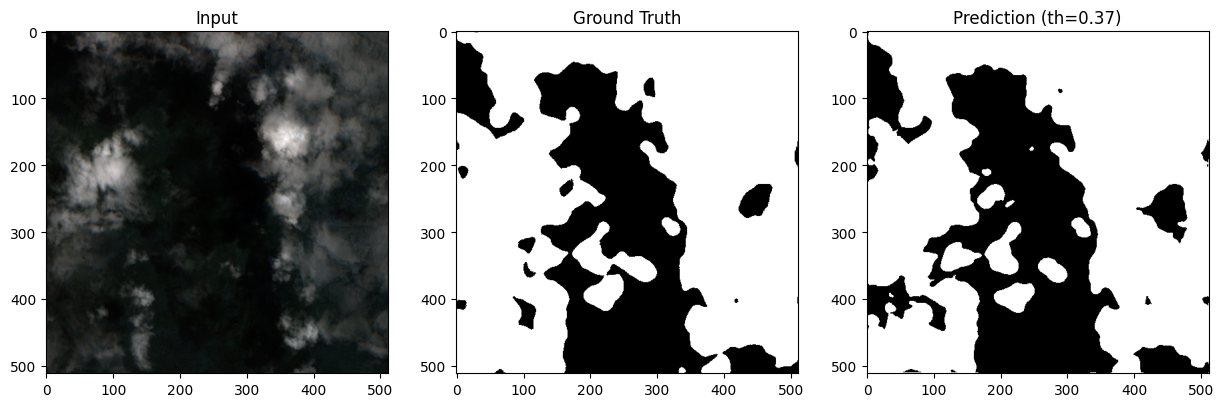

Validation: 100%|██████████| 265/265 [00:34<00:00,  7.61it/s]


Train Loss: 0.4282 | Val Loss: 0.2513
Val Dice: 0.9444±0.2584 | Threshold: 0.37
Precision: 0.9601 | Recall: 0.9489 | F1: 0.9545
New best model! Val Dice: 0.9444

Epoch 2/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.33it/s]


Train Loss: 0.2752 | Val Loss: 0.2156
Val Dice: 0.9493±0.2528 | Threshold: 0.23
Precision: 0.9592 | Recall: 0.9609 | F1: 0.9601
New best model! Val Dice: 0.9493

Epoch 3/50


Validation: 100%|██████████| 265/265 [00:37<00:00,  7.10it/s]


Train Loss: 0.2342 | Val Loss: 0.2167
Val Dice: 0.9430±0.2395 | Threshold: 0.23
Precision: 0.9492 | Recall: 0.9709 | F1: 0.9599

Epoch 4/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.40it/s]


Train Loss: 0.2191 | Val Loss: 0.1813
Val Dice: 0.9559±0.2364 | Threshold: 0.37
Precision: 0.9521 | Recall: 0.9705 | F1: 0.9612
New best model! Val Dice: 0.9559

Epoch 5/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.42it/s]


Train Loss: 0.2042 | Val Loss: 0.1938
Val Dice: 0.9470±0.2137 | Threshold: 0.23
Precision: 0.9624 | Recall: 0.9626 | F1: 0.9625

Epoch 6/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.36it/s]


Train Loss: 0.1963 | Val Loss: 0.1694
Val Dice: 0.9558±0.2041 | Threshold: 0.23
Precision: 0.9606 | Recall: 0.9712 | F1: 0.9659

Epoch 7/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.22it/s]


Train Loss: 0.1947 | Val Loss: 0.1658
Val Dice: 0.9591±0.2029 | Threshold: 0.37
Precision: 0.9660 | Recall: 0.9652 | F1: 0.9656
New best model! Val Dice: 0.9591

Epoch 8/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.15it/s]


Train Loss: 0.1895 | Val Loss: 0.1698
Val Dice: 0.9560±0.2026 | Threshold: 0.37
Precision: 0.9683 | Recall: 0.9601 | F1: 0.9642

Epoch 9/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.36it/s]


Train Loss: 0.1876 | Val Loss: 0.1781
Val Dice: 0.9526±0.2003 | Threshold: 0.23
Precision: 0.9641 | Recall: 0.9642 | F1: 0.9641

Epoch 10/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.08it/s]


Train Loss: 0.1854 | Val Loss: 0.1846
Val Dice: 0.9485±0.2036 | Threshold: 0.23
Precision: 0.9641 | Recall: 0.9627 | F1: 0.9634

Epoch 11/50


Validation:   0%|          | 0/265 [00:00<?, ?it/s]

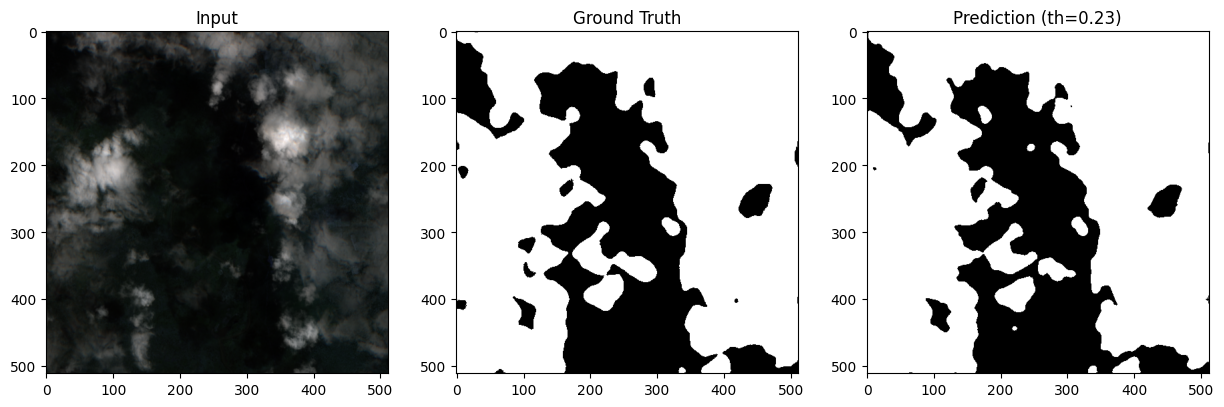

Validation: 100%|██████████| 265/265 [00:33<00:00,  7.84it/s]


Train Loss: 0.1864 | Val Loss: 0.1723
Val Dice: 0.9538±0.1956 | Threshold: 0.23
Precision: 0.9648 | Recall: 0.9683 | F1: 0.9666

Epoch 12/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.03it/s]


Train Loss: 0.1810 | Val Loss: 0.1961
Val Dice: 0.9443±0.2100 | Threshold: 0.23
Precision: 0.9633 | Recall: 0.9594 | F1: 0.9613

Epoch 13/50


Validation: 100%|██████████| 265/265 [00:33<00:00,  7.99it/s]


Train Loss: 0.1794 | Val Loss: 0.1872
Val Dice: 0.9471±0.2124 | Threshold: 0.23
Precision: 0.9687 | Recall: 0.9600 | F1: 0.9643

Epoch 14/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.15it/s]


Train Loss: 0.1704 | Val Loss: 0.1686
Val Dice: 0.9539±0.2059 | Threshold: 0.23
Precision: 0.9580 | Recall: 0.9716 | F1: 0.9647

Epoch 15/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.14it/s]


Train Loss: 0.1675 | Val Loss: 0.1614
Val Dice: 0.9575±0.1865 | Threshold: 0.23
Precision: 0.9654 | Recall: 0.9702 | F1: 0.9678

Epoch 16/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.25it/s]


Train Loss: 0.1661 | Val Loss: 0.1580
Val Dice: 0.9602±0.1961 | Threshold: 0.37
Precision: 0.9705 | Recall: 0.9635 | F1: 0.9670
New best model! Val Dice: 0.9602

Epoch 17/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.11it/s]


Train Loss: 0.1665 | Val Loss: 0.1569
Val Dice: 0.9601±0.1894 | Threshold: 0.37
Precision: 0.9692 | Recall: 0.9656 | F1: 0.9674

Epoch 18/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.35it/s]


Train Loss: 0.1664 | Val Loss: 0.1675
Val Dice: 0.9549±0.1895 | Threshold: 0.23
Precision: 0.9651 | Recall: 0.9662 | F1: 0.9656

Epoch 19/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.04it/s]


Train Loss: 0.1657 | Val Loss: 0.1566
Val Dice: 0.9600±0.1777 | Threshold: 0.37
Precision: 0.9735 | Recall: 0.9634 | F1: 0.9684

Epoch 20/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.34it/s]


Train Loss: 0.1661 | Val Loss: 0.1647
Val Dice: 0.9557±0.1915 | Threshold: 0.23
Precision: 0.9624 | Recall: 0.9706 | F1: 0.9665

Epoch 21/50


Validation:   0%|          | 0/265 [00:00<?, ?it/s]

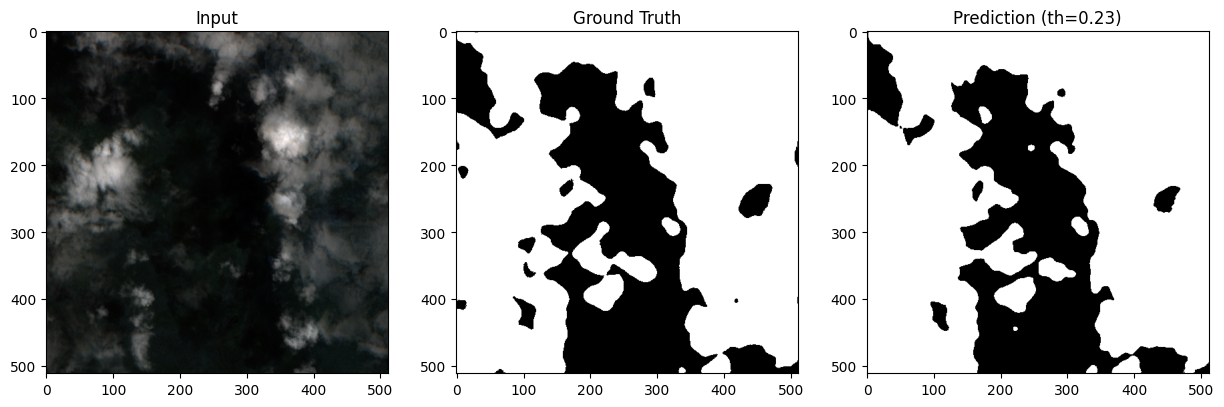

Validation: 100%|██████████| 265/265 [00:32<00:00,  8.17it/s]


Train Loss: 0.1651 | Val Loss: 0.1621
Val Dice: 0.9577±0.1904 | Threshold: 0.23
Precision: 0.9637 | Recall: 0.9707 | F1: 0.9672

Epoch 22/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.17it/s]


Train Loss: 0.1643 | Val Loss: 0.1626
Val Dice: 0.9559±0.1814 | Threshold: 0.23
Precision: 0.9695 | Recall: 0.9675 | F1: 0.9685

Epoch 23/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.28it/s]


Train Loss: 0.1611 | Val Loss: 0.1655
Val Dice: 0.9537±0.1729 | Threshold: 0.23
Precision: 0.9704 | Recall: 0.9655 | F1: 0.9679

Epoch 24/50


Validation: 100%|██████████| 265/265 [00:31<00:00,  8.39it/s]


Train Loss: 0.1600 | Val Loss: 0.1590
Val Dice: 0.9588±0.1876 | Threshold: 0.23
Precision: 0.9606 | Recall: 0.9744 | F1: 0.9674

Epoch 25/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.09it/s]


Train Loss: 0.1590 | Val Loss: 0.1737
Val Dice: 0.9511±0.1847 | Threshold: 0.23
Precision: 0.9735 | Recall: 0.9584 | F1: 0.9659

Epoch 26/50


Validation: 100%|██████████| 265/265 [00:32<00:00,  8.28it/s]


Train Loss: 0.1581 | Val Loss: 0.1635
Val Dice: 0.9554±0.1823 | Threshold: 0.23
Precision: 0.9654 | Recall: 0.9681 | F1: 0.9668
No improvement for 10 epochs. Early stopping!

Evaluating on test set...


Validation:   0%|          | 0/1058 [00:00<?, ?it/s]

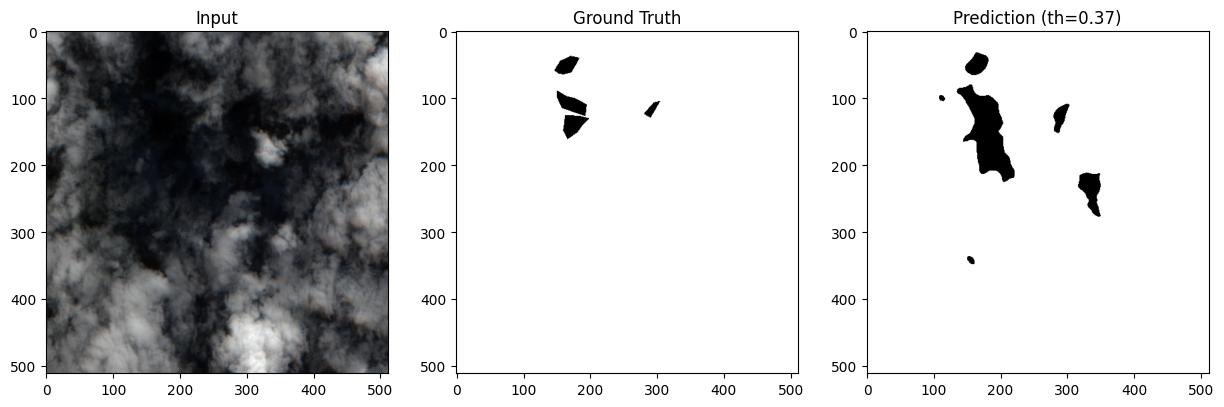

Validation: 100%|██████████| 1058/1058 [01:13<00:00, 14.32it/s]


--- Test Metrics ---
Validation Threshold Used: 0.37
Test Loss: 0.1653
Test Dice: 0.8889±0.2155
Test IoU: 0.8441±0.2314
Precision: 0.9656 | Recall: 0.9637 | F1: 0.9647


In [18]:
torch.multiprocessing.set_sharing_strategy('file_system')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    train_model()
except Exception as e:
    print(f"Critical error: {e}")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TESTONLY = False  # Set to True for testing only
if TESTONLY:
    batch_size = 4

    try:
        train_set, val_set, test_set = prepare_datasets('../data/processed')
    except Exception as e:
        print(f"Error preparing datasets: {e}")
        exit(1)

    pos_weight_value = compute_pos_weight(train_set)
    pos_weight = torch.tensor([pos_weight_value]).to(device)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

    model = SlimUNet(n_channels=4, n_classes=1).to(device)
    bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    dice = DicePixelLoss()

    def combined_loss_fn(logits, targets):
        return bce(logits, targets) + dice(logits, targets)

    criterion = combined_loss_fn

    test_model(model, test_loader, criterion, device)